## Creating an AI to play CartPole using deep Q-network with PyTorch

In [1]:
# Import stuff
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import time, random
from collections import namedtuple
from PIL import Image

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Create environment (unwrapped because we want to get access to some stuff)
env = gym.make('CartPole-v0').unwrapped

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Create a ReplayMemory class. This class will store tuples consisting of
# the important information in a transition: (state, action, next_state, reward). 
# This class is used to supply random memories when training the agent. 
# It has been shown that this improves the DQN training procedure.

# Use namedtuple to make the code easier to debug? 
# Seems like we can just use regular tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        # Store a transition in the memory
        transition = Transition(*args)
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition  # Overwrite old memory
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        # Get random memories
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
# Create a class for the deep Q-network. Our Q-network will be a convolutional
# neural network. It takes as input the current state of the environment (represented 
# by the current frame), and outputs theQ-value of each possible action.
class DQN(nn.Module):
    def __init__(self, c, h, w, outputs):
        '''
        Arguments:
            - c (int): number of channels of the input image
            - h (int): height of the input image
            - w (int): width of the input image
            - outputs (int): number of possible actions
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(c, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        # Try max pooling?
        
        # A function to quickly calculate the size of the dimension after convolution
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        final_c = 32
        final_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        final_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        linear_input_size = final_c * final_h * final_w
        self.fc = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.fc(x.view(x.size(0), -1))

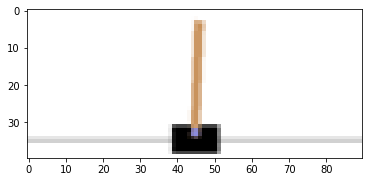

In [4]:
# Transformation to use later
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# Create functions to extract input image from the environment
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)
    # env.state[0] refers to the location of the middle of the cart relative to the middle of the world
    
def get_screen():
    # Get screen from the environment and convert it to (C, H, W)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # Since there's a lot of empty space on the top and bottom area of the screen, we can cut them out
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8), :]
    
    # We can also cut the edges of the screen and just get the area containing the cart
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:  # Cart is on the far left side of the screen
        screen = screen[:, :, :view_width]
    elif cart_location > (screen_width - view_width // 2):  # Cart is on the far right side of the screen
        screen = screen[:, :, -view_width:]
    else:  # Cart is on the middle of the screen
        screen = screen[:, :, (cart_location-view_width//2):(cart_location+view_width//2)]
        
    # Make the array contiguous, convert to float, rescale, and convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize and add a batch dimension (B, C, H, W)
    screen = resize(screen).unsqueeze(0).to(device)
    return screen

# Test these functions
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.show()
env.close()

In [5]:
# Function to select action. Use epsilon greedy as exploration strategy.
def select_action(policy_net, state, steps, eps_start=0.9, eps_end=0.05, eps_decay=200):
    epsilon = eps_end + (eps_start - eps_end) * np.exp(-1 * steps / eps_decay)
    sample = random.random()
    if sample > epsilon:
        # Exploit. Perform action with highest expected reward.
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Explore. Perform a random action
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [31]:
# Some model hyperparameters
BATCH_SIZE = 128
GAMMA = 0.99

# Function to perform a single step of optimization
def optimize_model(policy_net, target_net, optimizer, memory, batch_size=BATCH_SIZE, gamma=GAMMA):
    if len(memory) < batch_size:
        return  # Don't optimize the model if it doesn't have enough experience
    
    # Get a batch of memory
    transitions = memory.sample(batch_size)
    
    # Do a nifty trick to transpose this (B, 4) list into a (4, B) tuple
    batch = Transition(*zip(*transitions))
    
    # Get the list of states, actions, and rewards as tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Create a mask tensor of non-final states
    non_final_mask = torch.tensor([True if s is not None else False for s in batch.next_state],
                                  device=device, dtype=torch.bool)
    
    # Filter out the next_states of final states, which should be None anyway
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # Should be able to do the above task using tensor operation only
    
    # Compute Q-value for each state-action pair
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute value of each next state provided there's a next state. 
    # This value is computed using the older target net. But why?
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute expected Q-values
    expected_state_action_values = next_state_values * gamma + reward_batch
    
    # Compute Huber loss. Why use Huber loss?
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)  # is this gradient clipping?
    optimizer.step()

In [32]:
# Training hyperparameters
num_episodes = 500
max_steps = 1000
target_update = 10
memory_capacity = 2000

# Initialize models
init_screen = get_screen()
_, screen_channels, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n
policy_net = DQN(screen_channels, screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_channels, screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Set target net to evaluation mode only

optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(memory_capacity)

global_steps = 0
steps = []

# Training loop
for episode in range(num_episodes):
    # Initialize environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    # Collect memory until the episode is over
    for step in range(max_steps):
        # Select and perform an action
        action = select_action(policy_net, state, global_steps)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe next state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        global_steps += 1
        
        # Perform one optimization step
        optimize_model(policy_net, target_net, optimizer, memory)
        
        if done:
            steps.append(step)
            print("Episode {}: {}".format(episode, step))
            break
    
    # Update target network periodically
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print("Training complete")
env.close()

Episode 0: 22
Episode 1: 13
Episode 2: 19
Episode 3: 17
Episode 4: 19
Episode 5: 15
Episode 6: 21
Episode 7: 10
Episode 8: 16
Episode 9: 15
Episode 10: 16
Episode 11: 9
Episode 12: 32
Episode 13: 9
Episode 14: 11
Episode 15: 10
Episode 16: 8
Episode 17: 9
Episode 18: 11
Episode 19: 9
Episode 20: 13
Episode 21: 10
Episode 22: 25
Episode 23: 9
Episode 24: 47
Episode 25: 10
Episode 26: 8
Episode 27: 12
Episode 28: 9
Episode 29: 9
Episode 30: 9
Episode 31: 7
Episode 32: 9
Episode 33: 16
Episode 34: 8
Episode 35: 8
Episode 36: 13
Episode 37: 9
Episode 38: 9
Episode 39: 78
Episode 40: 12
Episode 41: 10
Episode 42: 20
Episode 43: 10
Episode 44: 30
Episode 45: 9
Episode 46: 11
Episode 47: 10
Episode 48: 9
Episode 49: 11
Episode 50: 10
Episode 51: 9
Episode 52: 12
Episode 53: 8
Episode 54: 16
Episode 55: 13
Episode 56: 9
Episode 57: 10
Episode 58: 9
Episode 59: 17
Episode 60: 11
Episode 61: 9
Episode 62: 16
Episode 63: 8
Episode 64: 11
Episode 65: 15
Episode 66: 9
Episode 67: 12
Episode 68: 9
E

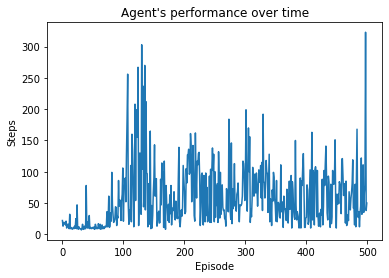

In [33]:
# Plot the agent's performance over time
plt.plot(steps)
plt.title("Agent's performance over time")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

In [22]:
env.close()